In [1]:
import numpy as np                                                                                                                                                                                    
import matplotlib.pyplot as plt                                                                                                                                                                             
import math       
from pprint import pprint
from TP3_functions.load_ag_news import load_ag_news                                                                                          
from TP3_functions.load_conll2000 import load_conll2000    

In [2]:
#Global vars
path = "./TP3_functions/"                                                                                                               
epsilon = [ 1E-10, 1E-5, 1 ]

## Classification de texte avec le modèle Naive Bayes

In [3]:
def estim_param_bayes(train_set,label):                                                                                                                                                                            
    Pi = {}                                                                                                                                                                                                        
    B  = {}                                                                                                                                                                                                        
                                                                                                                                                                                                                   
    sum_total = 0                                                                                                                                                                                                  
    for label, text in train_set:                                                                                                                                                                                  
        if label not in B.keys():                                                                                                                                                                                  
            B[label] = {}                                                                                                                                                                                          
            Pi[label] = 0                                                                                                                                                                                          
                                                                                                                                                                                                                   
        for word in text:                                                                                                                                                                                          
            if word not in B[label]:                                                                                                                                                                               
                B[label][word] = 0                                                                                                                                                                                 
            B[label][word] += 1                                                                                                                                                                                    
                                                                                                                                                                                                                   
        Pi[label] += 1                                                                                                                                                                                             
        sum_total +=1                                                                                                                                                                                              
                                                                                                                                                                                                                   
    for label in  Pi.keys():                                                                                                                                                                                       
        Pi[label] /= sum_total                                                                                                                                                                                     
                                                                                                                                                                                                                   
    for label in  B.keys():                                                                                                                                                                                        
        sum_label = sum(B[label].values())                                                                                                                                                                         
        for word in B[label]:                                                                                                                                                                                      
            B[label][word] /= sum_label                                                                                                                                                                            
            sum_total += sum_label                                                                                                                                                                                 
                                                                                                                                                                                                                   
    return Pi, B                                                           

In [4]:
def naive_bayes_predict(Pi, B, labels, epsilon, to_predic):                                                                                                                                                                                                                                                                                                                                                                          
    proba = {}                                                                                                                                                                                                     
    for label in labels:                                                                                                                                                                                           
        p = Pi[label]                                                                                                                                                                                              
        for word in to_predic:                                                                                                                                                                                     
            p *= B[label].get(word, 0) + epsilon                                                                                                                                                                   
        proba[label] = p                                                                                                                                                                                           
                                                                                                                                                                                                                   
    s_proba = sum(proba.values())                                                                                                                                                                                  
    for label in labels:                                                                                                                                                                                           
        proba[label] /= s_proba                                                                                                                                                                                    
    return proba                                

In [5]:
def naive_bayes_predict_log(Pi, B, labels, epsilon, to_predic):                                                                                                                                                                                                                                                                                                                                                                      
    proba = {}                                                                                                                                                                                                     
    for label in labels:                                                                                                                                                                                           
        p = math.log(Pi[label])                                                                                                                                                                                    
                                                                                                                                                                                                                   
        for word in to_predic:                                                                                                                                                                                     
            p += math.log(B[label].get(word, 0) + epsilon)                                                                                                                                                         
        proba[label] = p                                                                                                                                                                                           
                                                                                                                                                                                                                   
    return proba                                                          

In [6]:
def test_bayes_predict(Pi, B, labels, epsilon, test_set):                                                                                                                                                                                                                                                                                                                                                                           
    good_pred = 0                                                                                                                                                                                                  
    for label, text in test_set:                                                                                                                                                                                     
        proba = naive_bayes_predict_log(Pi,B,labels,epsilon,text)                                                                                                                                                  
        label_predicted = max(proba, key=proba.get)                                                                                                                                                                
        if label == label_predicted:                                                                                                                                                                               
            good_pred += 1                                                                                                                                                                                         
    return good_pred / len(test_set)                                       

In [20]:
def main_bayes():
    train_set, test_set = load_ag_news(path)      
    labels = [0,1,2,3]                            
    sentence_to_predic = ["Arsenal", "is", "a" , "londonian", "team", "."]   
                                                                            
    Pi, B = estim_param_bayes(train_set, labels) 
    print("Pi[1] = %.2f"%Pi[1])
    print("b1['London']=%.15f"%B[1]['London'])
    print("")
    
    p = naive_bayes_predict(Pi, B, labels, epsilon[1], sentence_to_predic)
    print("La prédiction pour la phrase " + str(sentence_to_predic) + " est :") 
    pprint(p)
    print("")
    
    for  e in epsilon:
        score = test_bayes_predict(Pi, B, labels, e, test_set)
        print(" score = %f avec epsilon = %.E"%(score, e))
                     

In [21]:
main_bayes()

Pi[1] = 0.25
b1['London']=0.000180362945743

La prédiction pour la phrase ['Arsenal', 'is', 'a', 'londonian', 'team', '.'] est :
{0: 0.0028278170810995774,
 1: 0.9924989725858532,
 2: 0.0007448195290411271,
 3: 0.003928390804006227}

 score = 0.901053 avec epsilon = 1E-10
 score = 0.894079 avec epsilon = 1E-05
 score = 0.490921 avec epsilon = 1E+00


* Le rôle d'epsilon est essentiel, sans lui on tombe rapidement dans l'underflow. Toutefois, il faut que sa valeur soit suffisante petite pour ne pas donner beaucoup de poids aux mots qui ont une probabilité nulle initialement.

## Étiquetage morpho-syntaxique avec une chaîne de Markov cachée

In [9]:
def estim_param_hmc(train_set):                                                                                                                                                                                    
    pi       = {}                                                                                                                                                                                                  
    a        = {}                                                                                                                                                                                                  
    b        = {}                                                                                                                                                                                                  
    nb_words = 0                                                                                                                                                                                                   
                                                                                                                                                                                                                   
    ## Pi calc                                                                                                                                                                                                     
    for sentence in train_set:                                                                                                                                                                                     
        for label, word in sentence:                                                                                                                                                                               
            if label not in pi.keys():                                                                                                                                                                             
                pi[label] = 1                                                                                                                                                                                      
            else :                                                                                                                                                                                                 
                pi[label] += 1                                                                                                                                                                                     
            nb_words += 1                                                                                                                                                                                          
                                                                                                                                                                                                                   
    for label in pi.keys():                                                                                                                                                                                        
        pi[label] /= nb_words                                                                                                                                                                                      
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
                                                                                                                                                                                                                   
    ## a calc                                                                                                                                                                                                      
    for sentence in train_set:                                                                                                                                                                                     
        for i in range(len(sentence)-1):                                                                                                                                                                           
            X_i   = sentence[i][0]                                                                                                                                                                                 
            X_i_1 = sentence[i+1][0]                                                                                                                                                                               
            if X_i not in a.keys():                                                                                                                                                                                
                a[X_i] = {}                                                                                                                                                                                        
            if X_i_1 not in a[X_i]:                                                                                                                                                                                
                a[X_i][X_i_1] = 1                                                                                                                                                                                  
            else :                                                                                                                                                                                                 
                a[X_i][X_i_1] += 1                                                                                                                                                                                 
                                                                                                                                                                                                                   
    for X_i in a.keys():                                                                                                                                                                                           
        X_i_sum = sum(a[X_i].values())                                                                                                                                                                             
        for X_i_1 in a[X_i]:                                                                                                                                                                                       
            a[X_i][X_i_1] /= X_i_sum            
            
                                                                                                                                                                                                                            
    ## b  calc                                                                                                                                                                                                     
    for sentence in train_set:                                                                                                                                                                                     
        for label, word in sentence:                                                                                                                                                                               
            if label not in b.keys():                                                                                                                                                                              
                b[label] = {}                                                                                                                                                                                      
            if word not in b[label]:                                                                                                                                                                               
                b[label][word] = 0                                                                                                                                                                                 
            b[label][word] +=1                                                                                                                                                                                     
                                                                                                                                                                                                                   
    for label in b.keys():                                                                                                                                                                                         
        sum_label = sum(b[label].values())                                                                                                                                                                         
        for word in b[label]:                                                                                                                                                                                      
            b[label][word] /=  sum_label                                                                                                                                                                           
                                                                                                                                                                                                                   
    return pi, a, b                          

In [10]:
def forward_backward(pi, a, b, epsilon, sentence):                                                                                                                                                                 
    alpha = {}                                                                                                                                                                                                     
    beta  = {}                                                                                                                                                                                                     
    gamma       = {}                                                                                                                                                                                               
    labels_pred = [''] * len(sentence)                                                                                                                                                                             
                                                                                                                                                                                                                   
    # init alpha                                                                                                                                                                                                   
    for label in pi.keys():                                                                                                                                                                                        
        alpha[label]    = [0] * len(sentence)                                                                                                                                                                     
        alpha[label][0] = pi[label] * b[label].get(sentence[0], epsilon)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
                                                                                                                                                                                                                   
    # calc alpha                                                                                                                                                                                                   
    for t in range(len(sentence) - 1):                                                                                                                                                                             
        for label in pi.keys():                                                                                                                                                                                    
            t_1 = t + 1                                                                                                                                                                                            
            alpha[label][t_1] = b[label].get(sentence[t_1], epsilon) * \
                                sum([alpha[j][t]*a[j].get(label,epsilon) for  j in pi.keys()])                                                                                                                                                                                                                                                          
          
        
    # init beta                                                                                                                                                                                                    
    for label in pi.keys():                                                                                                                                                                                        
        beta[label]    = [0] * len(sentence)                                                                                                                                                                       
        beta[label][-1] = 1                                                                                                                                                                                        
                                                                                                                                                                                                                   
    # calc beta                                                                                                                                                                                                    
    for t in range(len(sentence) - 2, -1, -1):                                                                                                                                                                     
        for label in pi.keys():                                                                                                                                                                                    
            t_1 = t + 1                                                                                                                                                                                            
            beta[label][t] = \
               sum([beta[j][t_1]*a[label].get(j,epsilon)*b[j].get(sentence[t_1],epsilon) \
                                                                    for j in pi.keys()])                                                                                                                                                                                                                                                                  
                                                                                                                                                                                                                                                                                                                                                                                                                                      
    # init gamma                                                                                                                                                                                                   
    for label in pi.keys():                                                                                                                                                                                        
        gamma[label] = list(map(lambda _a, _b: _a*_b, alpha[label], beta[label]))                                                                                                                                  
                                                                                                                                                                                                                   
    # pred                                                                                                                                                                                                         
    for i in range(len(sentence)):                                                                                                                                                                                 
        labels_pred[i] = max(gamma, key=lambda x: gamma[x][i])                                                                                                                                                     
                                                                                                                                                                                                                   
                                                                                                                                                                                                                   
    return labels_pred                                                                                                                                                                                             

In [11]:
def test_hmc(pi, a, b, epsilon, test_set):                                                                                                                                                                         
                                                                                                                                                                                                                   
        total_words = 0                                                                                                                                                                                            
        score       = 0                                                                                                                                                                                            
                                                                                                                                                                                                                   
        for label_sentence in test_set:                                                                                                                                                                            
            test_label    = [ l[0] for l in label_sentence]                                                                                                                                                        
            test_sentence = [ l[1] for l in label_sentence]                                                                                                                                                        
                                                                                                                                                                                                                   
            pred_label = forward_backward(pi, a, b, epsilon, test_sentence)                                                                                                                                        
                                                                                                                                                                                                                   
            total_words += len(test_sentence)                                                                                                                                                                      
            score       += sum(list(map(lambda p, t: p == t, pred_label, test_label)))                                                                                                                             
                                                                                                                                                                                                                   
        score /= total_words                                                                                                                                                                                       
        return score                                                                     

In [12]:
def main_markov():
    train_set, test_set = load_conll2000(path)                                    
    sentence_pred = ["I", "am", "a", "student", "in", "a", "French","school", "."]
    
    pi, a, b = estim_param_hmc(train_set)
    print("pi['ADJ']    = %.10f"    % pi['ADJ'])
    print("a_NUM[NOUM]  = %.10f"  % a['NUM']['NOUN'])
    print("b_PUNCT['.'] = %.10f" % b['PUNCT']['.'])
    print('')

    
    labels_pred = forward_backward(pi, a, b,epsilon[1], sentence_pred)
    print("Les labels prédits sur la phrase :")
    print('   ' + str([sentence_pred]))
    print('   ' + str([labels_pred]))
    print('')

    
    score = test_hmc(pi, a, b, epsilon[1], test_set)
    print("Le score du test de la chaine de Markov avec Forward-Backward "
          "pour epsilon=10E-5 est de : %.10f" %score)
    print('')                                                   

In [13]:
main_markov()

pi['ADJ']    = 0.0675964804
a_NUM[NOUM]  = 0.3482132114
b_PUNCT['.'] = 0.3601948561

Les labels prédits sur la phrase :
   [['I', 'am', 'a', 'student', 'in', 'a', 'French', 'school', '.']]
   [['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']]

Le score du test de la chaine de Markov avec Forward-Backward pour epsilon=10E-5 est de : 0.9385566836



## Filtrage de Kalman

In [14]:
def estim_param_kalman(Y):                                                                                                                                                                                         
    ab2  = (Y[:-1] * Y[1:]).mean()                                                                                                                                                                                 
    a2b2 = (Y[:-2] * Y[2:]).mean()                                                                                                                                                                                 
                                                                                                                                                                                                                   
    a = a2b2 / ab2                                                                                                                                                                                                 
    b = ab2 / np.sqrt(a2b2)                                                                                                                                                                                        
                                                                                                                                                                                                                   
    return a,b                                                                                                                                                                                                 

In [15]:
def kalman_filter(a, b, Y):                                                                                                                                                                                        
    X_hat    = np.array([b*Y[0]])                                                                                                                                                                                  
    sigma_t_t =  1 - b**2                                                                                                                                                                                          
                                                                                                                                                                                                                   
    for i in range(len(Y)-1):                                                                                                                                                                                      
        # pred                                                                                                                                                                                                     
        x_hat_t1_t = a * X_hat[i]                                                                                                                                                                                  
        sigma_t1_t = 1 - a**2 + a**2 * sigma_t_t                                                                                                                                                                   
                                                                                                                                                                                                                   
        # update                                                                                                                                                                                                   
        y_hat_t_1   = Y[i+1] - b *  x_hat_t1_t                                                                                                                                                                     
        S_t_1       = b**2 * sigma_t1_t + 1 - b**2                                                                                                                                                                 
        K_t_1       = ( b / S_t_1 ) * sigma_t1_t                                                                                                                                                                   
        x_hat_t1_t1 = x_hat_t1_t + K_t_1  * y_hat_t_1                                                                                                                                                              
        sigma_t1_t1 = (1 - b * K_t_1) * sigma_t1_t                                                                                                                                                                 
                                                                                                                                                                                                                   
        X_hat = np.append(X_hat, x_hat_t1_t1)                                                                                                                                                                      
        x_hat_t1_t  = x_hat_t1_t1                                                                                                                                                                                  
        sigma_t1_t  = sigma_t1_t1                                                                                                                                                                                  
                                                                                                                                                                                                                   
    return X_hat                             

In [16]:
def EQM_sig(X1, X2):                                                                                                                                                                                               
    return ( (X1 - X2)**2).mean()                                                                                                                                                                                  

In [22]:
def plot_sigs(X, Y, X_hat):                                                                                                                                                                                                                                                                                                                                                                                                           
    with plt.style.context('ggplot'):                                                                                                                                                                              
        fig, ax = plt.subplots(figsize=(20,15))                                                                                                                                                                    
                                                                                                                                                                                                                   
        plt.plot(X[:100],     label = "Signal d'origine")                                                                                                                                                          
        plt.plot(X_hat[:100], label = "Signal restitué")                                                                                                                                                           
                                                                                                                                                                                                                   
    plt.title("100 premières itérations du signal restauré et le signal d’origine.")                                                                                                                         
    plt.legend()                                                                                                                                                                                                   
    plt.show()                                                

In [18]:
def main_kalman():       
    X = np.loadtxt(path + "signal_X.txt") 
    Y = np.loadtxt(path + "signal_Y.txt")
    
    a, b = estim_param_kalman(Y)   
    X_hat = kalman_filter(a, b, Y) 
    
    error_x_hat = EQM_sig(X,X_hat) 
    error_y     = EQM_sig(X,Y) 
    print("Erreur quadratique moyenne entre X et X_hat: %.5f" %error_x_hat)
    print("Erreur quadratique moyenne entre X et Y    : %.5f" %error_y)
    print('')
    print("L'erreur quadratique moyenne par rapport au signal d'origine est inférieur "
          "pour le signal restauré. Ce qui prouve qu'il y a bien eu une amélioration "
          "avec le filtre de kalman (un signal plus proche du signal original que Y)")
    print('')
    
    plot_sigs(X, Y, X_hat)

    

Erreur quadratique moyenne entre X et X_hat: 0.17448
Erreur quadratique moyenne entre X et Y    : 0.20226

L'erreur quadratique moyenne par rapport au signal d'origine est inférieur pour le signal restauré. Ce qui prouve qu'il y a bien eu une amélioration avec le filtre de kalman (un signal plus proche du signal original que Y)



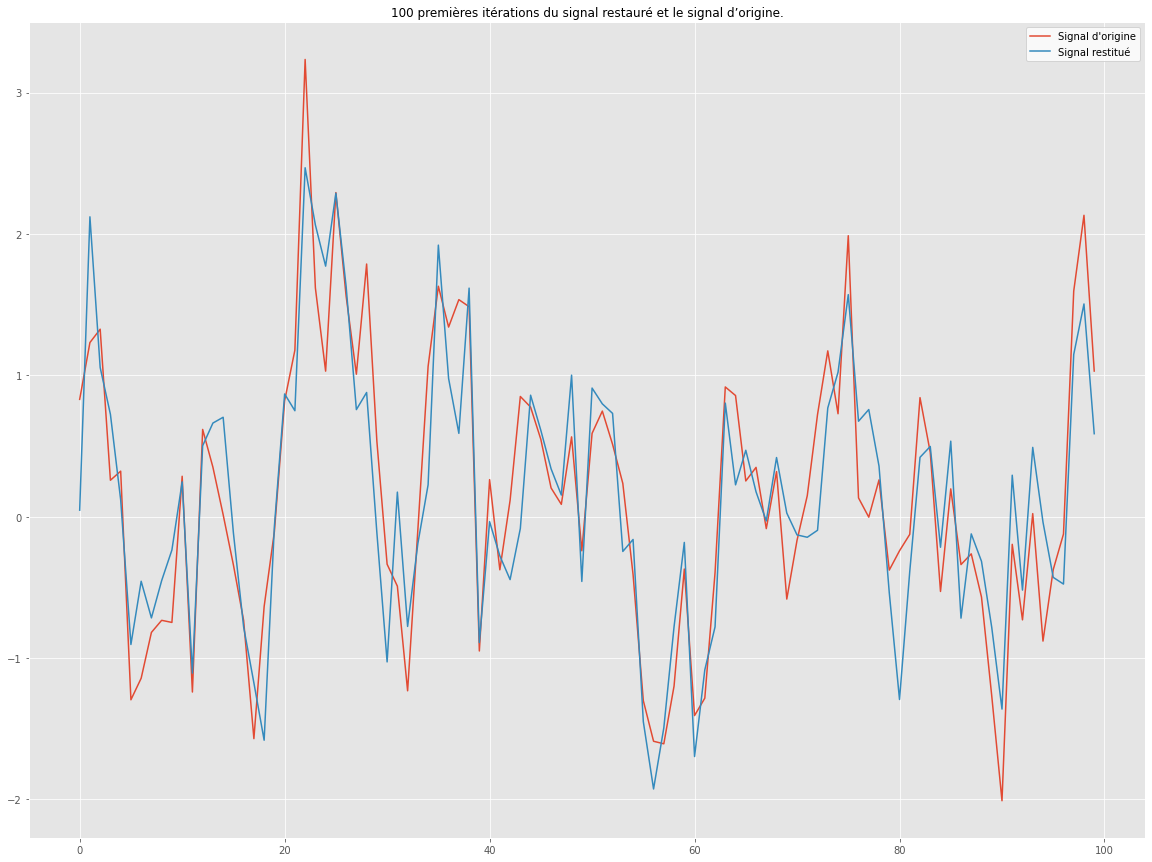

In [23]:
main_kalman()